# Capstone Project - The Battle of Neighborhoods
## 1. A description of the problem and a discussion of the background. (15 marks)
   Starting from the California gold rush which brought over twenty thousand Chinese immigrants to the United States, Chinese restaurants were spread all over to America's east coast, such as New York City, and west coast, San Fransisco. People like to use the term "melt pot" to describe the culture of New York City. With its diverse culture, we want to examine a good location to open a Chinese restaurant in Manhattan, which has a strong Chinese demographic.
   
## 2. A description of the data and how it will be used to solve the problem. (15 marks)
   To find the best location to open a Chinese restaurant, I will use New York City data that contains the latitude and longitude of all Chinese restaurants in Manhattan. The data is public available: https://cocl.us/new_york_dataset.</p>
   To have more information on each Chinese restaurants, I will use the Foursquare API. 

import libraries 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

get geo location of address

In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=30
    CLIENT_ID = 'EB414E55S3IE2W0NPP51WEPSSMRJ4IUQHZKNPS0FHK24FLGH'# your Foursquare ID
    CLIENT_SECRET ='1G0OLXMNIDQSEZZL1VPL00TI1BJ1W25YF3W1EO3GMLR5VSKY' # your Foursquare Secret
    VERSION = '20190327' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'EB414E55S3IE2W0NPP51WEPSSMRJ4IUQHZKNPS0FHK24FLGH' # your Foursquare ID
    CLIENT_SECRET = '1G0OLXMNIDQSEZZL1VPL00TI1BJ1W25YF3W1EO3GMLR5VSKY' # your Foursquare Secret
    VERSION = '20190327' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Read new york data

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Select manhattan as the only borough to explore

In [6]:
new_york_data=get_new_york_data()
manhattan_data=new_york_data[new_york_data.Borough == 'Manhattan']

In [7]:
manhattan_data

,Borough,Neighborhood,Latitude,Longitude
6,Manhattan,Marble Hill,40.876551,-73.910660
100,Manhattan,Chinatown,40.715618,-73.994279
101,Manhattan,Washington Heights,40.851903,-73.936900
102,Manhattan,Inwood,40.867684,-73.921210
103,Manhattan,Hamilton Heights,40.823604,-73.949688
104,Manhattan,Manhattanville,40.816934,-73.957385
105,Manhattan,Central Harlem,40.815976,-73.943211
106,Manhattan,East Harlem,40.792249,-73.944182
107,Manhattan,Upper East Side,40.775639,-73.960508
108,Manhattan,Yorkville,40.775930,-73.947118


In [8]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in manhattan_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant'] 
    print('(',count,'/',len(manhattan_data),')','Chinese Restaurant in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 40 ) Chinese Restaurant in Marble Hill, Manhattan:0
( 2 / 40 ) Chinese Restaurant in Chinatown, Manhattan:1
( 3 / 40 ) Chinese Restaurant in Washington Heights, Manhattan:0
( 4 / 40 ) Chinese Restaurant in Inwood, Manhattan:0
( 5 / 40 ) Chinese Restaurant in Hamilton Heights, Manhattan:0
( 6 / 40 ) Chinese Restaurant in Manhattanville, Manhattan:0
( 7 / 40 ) Chinese Restaurant in Central Harlem, Manhattan:0
( 8 / 40 ) Chinese Restaurant in East Harlem, Manhattan:0
( 9 / 40 ) Chinese Restaurant in Upper East Side, Manhattan:0
( 10 / 40 ) Chinese Restaurant in Yorkville, Manhattan:0
( 11 / 40 ) Chinese Restaurant in Lenox Hill, Manhattan:0
( 12 / 40 ) Chinese Restaurant in Roosevelt Island, Manhattan:0
( 13 / 40 ) Chinese Restaurant in Upper West Side, Manhattan:1
( 14 / 40 ) Chinese Restaurant in Lincoln Square, Manhattan:0
( 15 / 40 ) Chinese Restaurant in Clinton, Manhattan:0
( 16 / 40 ) Chinese Restaurant in Midtown, Manhattan:1
( 17 / 40 ) Chinese Restaurant in Murray Hill, Ma

In [9]:
chinese_rest_ny

,Borough,Neighborhood,ID,Name
0,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
1,Manhattan,Upper West Side,5529bfd8498ec6ce692d8015,Han Dynasty
2,Manhattan,Midtown,5e024619523cd2000769f67a,Xi’an Famous Foods
3,Manhattan,Murray Hill,4e3484038877beb5e9a22a0b,Café China
4,Manhattan,Chelsea,44e9b421f964a520a5371fe3,Buddakan
5,Manhattan,Lower East Side,5b380f649deb7d00399fdf9d,Kings County Imperial
6,Manhattan,Tribeca,5237264111d27e8e90c10357,China Blue
7,Manhattan,West Village,526eeb54498e9674b5d9034a,Decoy
8,Manhattan,West Village,4e1df590b61c7cb34d9735a8,RedFarm
9,Manhattan,Manhattan Valley,529e3657498efb17e9c800b7,Xi'an Famous Foods


Plot the number of Chinese Resturants for each neighborhood in Manhattan

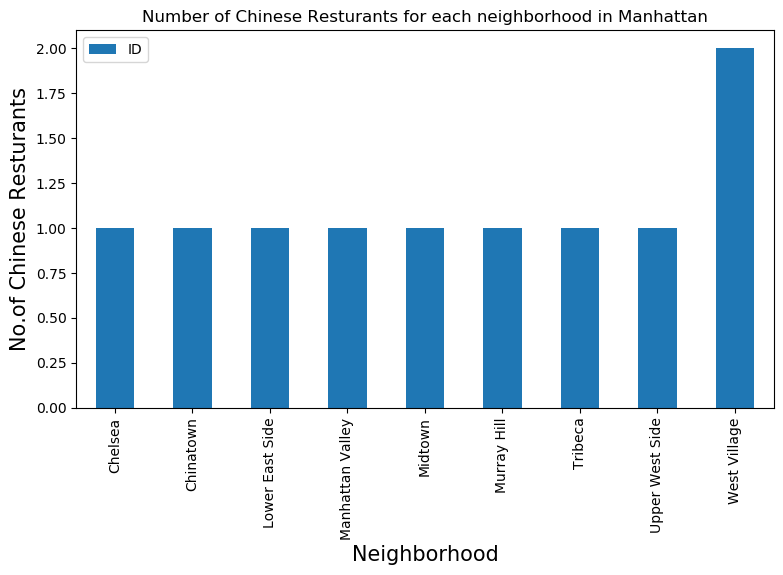

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each neighborhood in Manhattan')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Get the likes, rating and tips information from Foursquare API

In [11]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                Name  Likes  Rating  Tips
0  5894c9a15e56b417cf79e553  Xi'an Famous Foods    102     8.9    29
( 1 / 10 ) processed
                         ID         Name  Likes  Rating  Tips
0  5529bfd8498ec6ce692d8015  Han Dynasty    317     8.9    66
( 2 / 10 ) processed
                         ID                Name  Likes  Rating  Tips
0  5e024619523cd2000769f67a  Xi’an Famous Foods      1     9.0     2
( 3 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e3484038877beb5e9a22a0b  Café China   1034     9.0   273
( 4 / 10 ) processed
                         ID      Name  Likes  Rating  Tips
0  44e9b421f964a520a5371fe3  Buddakan   1473     9.2   520
( 5 / 10 ) processed
                         ID                   Name  Likes  Rating  Tips
0  5b380f649deb7d00399fdf9d  Kings County Imperial     68     9.1    10
( 6 / 10 ) processed
                         ID        Name  Likes  Rating  Tips
0  5237264111d27e8e90c10357  

In [12]:
chinese_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods,102,8.9,29
1,Manhattan,Upper West Side,5529bfd8498ec6ce692d8015,Han Dynasty,317,8.9,66
2,Manhattan,Midtown,5e024619523cd2000769f67a,Xi’an Famous Foods,1,9.0,2
3,Manhattan,Murray Hill,4e3484038877beb5e9a22a0b,Café China,1034,9.0,273
4,Manhattan,Chelsea,44e9b421f964a520a5371fe3,Buddakan,1473,9.2,520
5,Manhattan,Lower East Side,5b380f649deb7d00399fdf9d,Kings County Imperial,68,9.1,10
6,Manhattan,Tribeca,5237264111d27e8e90c10357,China Blue,346,8.8,85
7,Manhattan,West Village,526eeb54498e9674b5d9034a,Decoy,331,9.1,107
8,Manhattan,West Village,4e1df590b61c7cb34d9735a8,RedFarm,707,8.8,287
9,Manhattan,Manhattan Valley,529e3657498efb17e9c800b7,Xi'an Famous Foods,295,8.5,80


In [13]:
chinese_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
Borough         10 non-null object
Neighborhood    10 non-null object
ID              10 non-null object
Name            10 non-null object
Likes           10 non-null object
Rating          10 non-null float64
Tips            10 non-null object
dtypes: float64(1), object(6)
memory usage: 640.0+ bytes


Change the data type of "Tipes" and "Likes" into float 

In [14]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')

Find the restaurant with maximum Likes

In [15]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1473
Rating                               9.2
Tips                                 520
Name: 4, dtype: object

Find the restaurant with maximum Likes

In [16]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1473
Rating                               9.2
Tips                                 520
Name: 4, dtype: object

Find the restaurant with maximum Tips

In [18]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [19]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)


,Neighborhood,Average Rating
0,Chelsea,9.20
2,Lower East Side,9.10
4,Midtown,9.00
5,Murray Hill,9.00
8,West Village,8.95
1,Chinatown,8.90
7,Upper West Side,8.90
6,Tribeca,8.80
3,Manhattan Valley,8.50


Find neighbourhoods that have an average rating over 9.0

In [20]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]


In [21]:
ny_neighborhood_stats


,Neighborhood,Average Rating
0,Chelsea,9.2
2,Lower East Side,9.1
4,Midtown,9.0
5,Murray Hill,9.0


Merge the data with location data with latitude and longitude 

In [22]:
ny_neighborhood_stats=pd.merge(manhattan_data, ny_neighborhood_stats,on='Neighborhood')


In [23]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [24]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Midtown,40.754691,-73.981669,9.0
1,Manhattan,Murray Hill,40.748303,-73.978332,9.0
2,Manhattan,Chelsea,40.744035,-74.003116,9.2
3,Manhattan,Lower East Side,40.717807,-73.980890,9.1


Create a map with all these restaurants presented

In [25]:
ny_map = folium.Map(location=geo_location('New York City'), zoom_start=14)

In [26]:
incidents = folium.map.FeatureGroup()
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [27]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [28]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Discussion

West Village is the neighborhood that has the average maximum rating of 9.25 for Chinese restaurants. Joe's Shanghai has the highest likes and tips in the neighborhood of Chinatown with total likes of 1271 and total tips of 563. Joe's Shanghai is the type of Shanghai cuisine. Since there is no similar Shanghai cuisine in West Village, we can consider open one there. 